In [1]:
from rdkit import Chem
import pandas as pd
from rdkit.Chem import PandasTools

from IPython.display import HTML
def show_df(df):
    return HTML(df.to_html(notebook=True))

# Read Moonshot CSV to Dataframe

In [2]:
#Read moonshot file
moonshot_file = "../../covid_submissions_all_info.csv"
df = pd.read_csv(moonshot_file)

/tmp/ipykernel_15219/1315103461.py:3: DtypeWarning: Columns (3,6,7,9,10,11,12,13,14,15,18,19,27,28,29,30,31,32,33,34,35,36,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,66,67,69,70,71,72,73,74,75,76,84,85,86,87,89,90,91,92,93,94,95,96,104,105,106,107,109,110,111,112,113,114,115,116,124,125,126,127,129,130,131,132,133,134,135,136,144,145,146,147,149,150,151,152,153,154,155,156,164,165,166,167,169,170,171,172,173,174,175,176,184,185,186,187,189,190,191,192,193,194,195,196,204,205,206,207,209,210,211,212,213,214,215,216,224,225,226,227,229,230,231,232,233,234,235,236,244,245,246,247,249,253,254,255,256,257,258,259,275,276) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(moonshot_file)


# Add column indicating if docked structure already exists
### nb. Docked strucutures are supposed to exist for all molecules already

In [3]:
#Add docked column (bool) indicating if mol as docked structure
docked_name = []
with open("../../../molecules_with_poses.txt") as file:
    for line in ((file.readlines()[0]).split(", ")):
        docked_name.append(line.strip("'").strip("['").strip("']"))
df["docked"] = False
df.loc[df["CID"].isin(docked_name), "docked"] = True

In [4]:
#Select rows which have both assay data and docked structure
df.loc[df["ASSAYED"]&df["docked"],["CID","SMILES","ASSAYED","docked"]]

,CID,SMILES,ASSAYED,docked
24,DAR-DIA-23aa0b97-8,N#Cc1cccc(NC(=O)Nc2cncc(N)c2)c1,True,True
27,DAR-DIA-23aa0b97-11,N#Cc1cccc(NC(=O)Nc2c[nH]c3ncccc23)c1,True,True
35,DAR-DIA-23aa0b97-19,N#Cc1cccc(NC(=O)Cc2cncc3ccccc23)c1,True,True
36,DAR-DIA-23aa0b97-20,O=C(Cc1cncc2ccccc12)Nc1ccccc1,True,True
107,WAR-XCH-eb7b662f-2,N#Cc1cc(Cl)cc(NC(=O)Nc2cccnc2)c1,True,True
...,...,...,...,...
4520,LON-WEI-adc59df6-45,C=CC(=O)N(c1ccc(C(C)(C)C)cc1)C(C(=O)Nc1ccc(OC)...,True,True
4522,LON-WEI-adc59df6-47,C=CC(=O)N(c1ccc(C(C)(C)C)cc1)C(C(=O)NCCc1cccc(...,True,True
4528,LON-WEI-adc59df6-53,C=CC(=O)N(c1ccc(C(C)(C)C)cc1)C(C(=O)NC(C)(C)C)...,True,True
4553,LON-WEI-adc59df6-78,C=CC(=O)N(c1ccc(CCC#N)cc1)C(C(=O)NC(C)(C)C)c1c...,True,True


# Create murcko hash dataframe (only run once)
##### To save time, results were saved to hash csv, and are now merged with the main df
##### This means molecule objects do not need to be constructed, avoiding bug with visualising rdkit mols in df

In [5]:
#Add murcko hash and generic murcko hash to df
from diy_functions import GetTrueScaffold
from rdkit.Chem import rdMolHash
from rdkit.Chem.rdMolHash import HashFunction

def GetHashFromMol(mol):
    scaffold = GetTrueScaffold(mol,generic=False)
    return(rdMolHash.MolHash(scaffold,HashFunction.MurckoScaffold))
    
def GetGenericHashFromMol(mol):
    scaffold = GetTrueScaffold(mol,generic=True)
    return(rdMolHash.MolHash(scaffold,HashFunction.MurckoScaffold))

In [6]:
#PandasTools.AddMoleculeColumnToFrame(df,'SMILES','Molecule')
#df["mHash"] = df.apply(lambda x: (GetHashFromMol(x["Molecule"])), axis = 1)
#df["mHashGeneric"] = df.apply(lambda x: (GetGenericHashFromMol(x["Molecule"])), axis = 1)

In [7]:
#Save dataframe with hash data for easy analysis later
#df.to_csv(path_or_buf="MoonshotHashData.csv", columns=["CID","SMILES","mHash","mHashGeneric"],index_label="index")

# Get hash data from csv and merge with main df

In [8]:
hash_df = pd.read_csv("MoonshotHashData.csv",index_col="index")
df = pd.merge(df,hash_df[["mHash","mHashGeneric"]], left_index=True,right_on="index")

In [9]:
show_df(df.loc[df["ASSAYED"]&df["docked"],["CID","SMILES","ASSAYED","docked","mHash","mHashGeneric"]])

,CID,SMILES,ASSAYED,docked,mHash,mHashGeneric
index,,,,,,
24,DAR-DIA-23aa0b97-8,N#Cc1cccc(NC(=O)Nc2cncc(N)c2)c1,True,True,c1ccc(NCNc2cccnc2)cc1,C1CCC(CCCC2CCCCC2)CC1
27,DAR-DIA-23aa0b97-11,N#Cc1cccc(NC(=O)Nc2c[nH]c3ncccc23)c1,True,True,c1ccc(NCNc2c[nH]c3ncccc23)cc1,C1CCC(CCCC2CCC3CCCCC32)CC1
35,DAR-DIA-23aa0b97-19,N#Cc1cccc(NC(=O)Cc2cncc3ccccc23)c1,True,True,c1ccc(NCCc2cncc3ccccc23)cc1,C1CCC(CCCC2CCCC3CCCCC32)CC1
36,DAR-DIA-23aa0b97-20,O=C(Cc1cncc2ccccc12)Nc1ccccc1,True,True,c1ccc(NCCc2cncc3ccccc23)cc1,C1CCC(CCCC2CCCC3CCCCC32)CC1
107,WAR-XCH-eb7b662f-2,N#Cc1cc(Cl)cc(NC(=O)Nc2cccnc2)c1,True,True,c1ccc(NCNc2cccnc2)cc1,C1CCC(CCCC2CCCCC2)CC1
126,TRY-UNI-714a760b-3,Cc1c(N)cncc1NC(=O)Cc1cccc(Cl)c1,True,True,c1ccc(CCNc2cccnc2)cc1,C1CCC(CCCC2CCCCC2)CC1
129,TRY-UNI-714a760b-6,Cc1ccncc1NC(=O)Cc1cccc(Cl)c1,True,True,c1ccc(CCNc2cccnc2)cc1,C1CCC(CCCC2CCCCC2)CC1
135,TRY-UNI-714a760b-12,Cc1ccncc1NC(=O)Nc1cccc(Cl)c1,True,True,c1ccc(NCNc2cccnc2)cc1,C1CCC(CCCC2CCCCC2)CC1
141,TRY-UNI-714a760b-18,Cc1ccncc1NC(=O)C(C)c1cccc(Cl)c1,True,True,c1ccc(CCNc2cccnc2)cc1,C1CCC(CCCC2CCCCC2)CC1


# Murcko Scaffold Analysis
#### df now contains column with murcko scaffold hash and generic murcko scaffold hash. This uniquely identifies the scaffold structure. These can be grouped to find all molecules with same scaffold.

In [10]:
#Group all molecules by generic murcko hash
#Count number of molecules with same generic murcko scaffold
#show largest 20 scaffold sets
df.groupby("mHashGeneric")["CID"].count().nlargest(20)

mHashGeneric
C1CCC2C(C1)CCCC2CCC1CCCC2CCCCC21                1618
C1CCC(CCCC2CCCCC2)CC1                            867
C1CCCCC1                                         607
C1CCC(CCCC2CCCC3CCCCC32)CC1                      522
C1CCCC1                                          507
C1CCC(CC2CCCCC2)CC1                              392
C1CCC(CCC2CCCCC2)CC1                             335
C1CCC(CC2CCCC2)CC1                               274
C1CCC(CCCCC2CCCCC2)CC1                           268
C1CCC(C2CCCC2)CC1                                261
C1CCC2CCCC2C1                                    260
C1CCC(CCCC2CCC3CCCCC32)CC1                       226
C1CCC(CCC2CCCC2)CC1                              225
C1CCC(CCCCC(C2CCCCC2)C(CC2CCCC2)C2CCCCC2)CC1     225
C1CCC(CCCC2CCCC2)CC1                             204
C1CCC2C(C1)CCCC2C1CCC2(CCCC3CCCCC32)C1           191
C1CCC2CCCCC2C1                                   186
C1CCC2C(C1)CCCC2CCC1CCCC2CCCC21                  175
C1CCC2C(C1)CCCC2CCC1CCC2CCCCC21  

In [11]:
#Group all molecules by murcko hash
#Count number of molecules with same generic murcko scaffold
#show largest 20 scaffold sets
df.groupby("mHash")["CID"].count().nlargest(20)

mHash
c1ccc2c(c1)CNCC2CNc1cncc2ccccc12                   548
c1ccc2c(c1)OCCC2CNc1cncc2ccccc12                   538
c1ccc(CCNc2cncc3ccccc23)cc1                        304
c1ccccc1                                           263
c1ccc(CCNc2cccnc2)cc1                              187
c1ccc(CNCc2cncnc2)cc1                              140
c1ccc2c(c1)CNCC21CCN(c2cncc3ccccc23)C1             119
c1ccc(CN2CCNCC2)cc1                                118
c1ccncc1                                           118
c1ccc2c(c1)CN(SCC1CC1)CC2CNc1cncc2ccccc12          114
c1ccc2[nH]ccc2c1                                   110
c1ccc2c(c1)NCCC2CNc1cncc2ccccc12                   107
c1c[s]cn1                                          102
c1ccc(NCNc2cccnc2)cc1                               92
c1ccc2c(c1)CN(SCC1CC1)CC21CCN(c2cncc3ccccc23)C1     92
c1ccc2c(c1)SNCC2CNc1cncc2ccccc12                    92
c1cocn1                                             79
c1ccc(SN2CCNCC2)cc1                                 76
c1cn

# Murcko scaffold intersection with docking data

In [12]:
#subset of df with docking data
#Group by murcko scaffold and count
df.loc[df["docked"]].groupby("mHash")["CID"].count().nlargest(10)

mHash
c1ccccc1                            102
c1ccc2[nH]ccc2c1                     85
c1ccc(NCNc2cccnc2)cc1                66
c1ccc(CN2CCNCC2)cc1                  59
c1ccc2c(c1)COC(C1CCCCC1)C2           55
c1ccc(CCNc2cccnc2)cc1                46
c1ccc(NCC(Nc2ccccc2)c2cccnc2)cc1     40
c1ccncc1                             39
c1ccc(NCc2cccnc2)cc1                 38
c1cncc(NCCC2CCCCC2)c1                32
Name: CID, dtype: int64

In [13]:
df.loc[df["docked"]].groupby("mHashGeneric")["CID"].count().nlargest(10)

mHashGeneric
C1CCC(CCCC2CCCCC2)CC1               256
C1CCCCC1                            203
C1CCC(CC2CCCCC2)CC1                 177
C1CCC2CCCC2C1                       118
C1CCC(CCC2CCCCC2)CC1                104
C1CCC(C2CCC3CCCCC3C2)CC1             71
C1CCC(CCC(CC2CCCCC2)C2CCCCC2)CC1     70
C1CCC(CC2CCCC2)CC1                   58
C1CCC(CC2CCCC3CCCC32)CC1             58
C1CCC(CCCCC2CCCCC2)CC1               54
Name: CID, dtype: int64

# Murcko intersection with assay data

In [14]:
df.loc[df["ASSAYED"]].groupby("mHash")["CID"].count().nlargest(10)

mHash
c1ccc2c(c1)CNCC2CNc1cncc2ccccc12                   138
c1ccc2c(c1)OCCC2CNc1cncc2ccccc12                   126
c1ccc(CCNc2cncc3ccccc23)cc1                        112
c1ccc2c(c1)CN(SCC1CC1)CC2CNc1cncc2ccccc12           44
c1ccc2c(c1)NCCC2CNc1cncc2ccccc12                    38
c1ccc(CCNc2cccnc2)cc1                               37
c1ccc2c(c1)CNCC21CCN(c2cncc3ccccc23)C1              34
c1ccc2c(c1)CN(SCC1CC1)CC21CCN(c2cncc3ccccc23)C1     25
c1ccc2c(c1)SNCC2CNc1cncc2ccccc12                    24
c1ccc(SN2CCNCC2)cc1                                 23
Name: CID, dtype: int64

In [41]:
df.loc[df["ASSAYED"]].groupby("mHashGeneric")["CID"].count().nlargest(50)

mHashGeneric
C1CCC2C(C1)CCCC2CCC1CCCC2CCCCC21                         386
C1CCC(CCCC2CCCC3CCCCC32)CC1                              181
C1CCC(CCCCC(C2CCCCC2)C(CC2CCCC2)C2CCCCC2)CC1             116
C1CCC(CCCC2CCCCC2)CC1                                     63
C1CCC2C(C1)CCCC2C1CCC2(CCCC3CCCCC32)C1                    56
C1CCC(CC2CCCCC2)CC1                                       53
C1CCC(CCCC2CCC3CCCCC32)CC1                                51
C1CCC2C(C1)CCCC2CCC1CC(CCC2CC2)CC2CCCCC21                 46
C1CCC(CCCCCC2CCCC3CCCCC23)CC1                             36
C1CCC2C(C1)CCCC2CCC1CCC2CCCCC21                           27
C1CCCCC1                                                  27
C1CCC2C(C1)CCCC2C1CCC2(CC(CCC3CC3)CC3CCCCC32)C1           26
C1CC(CCC2CC3CCCCC3C(CCC3CCCC4CCCCC43)C2)C1                21
C1CCC(CCC2CCCC3CCCCC32)CC1                                21
C1CCC(CCCC2CCCC2)CC1                                      20
C1CCC(CCCC2CCCC3CCCC23)CC1                                20
C1CCC(CCCCC

# Murcko intersection with both docking and assay data

In [16]:
df.loc[df["docked"]&df["ASSAYED"]].groupby("mHash")["CID"].count().nlargest(10)

mHash
c1ccc(CN2CCNCC2)cc1                 9
c1ccc(NCc2cccnc2)cc1                8
c1ccc(CCNc2cccnc2)cc1               6
c1ccccc1                            5
c1ccc(NCC(Nc2ccccc2)c2cccnc2)cc1    4
c1ccc(NCNc2cccnc2)cc1               4
c1ccc(C2CNCc3ccccc32)cc1            3
c1ccc(SN2CCNCC2)cc1                 3
c1ccc2c(CN3CCNCC3)cccc2c1           3
c1cncc(CN2CCNCC2)c1                 3
Name: CID, dtype: int64

In [17]:
df.loc[df["docked"]&df["ASSAYED"]].groupby("mHashGeneric")["CID"].count().nlargest(10)

mHashGeneric
C1CCC(CC2CCCCC2)CC1                  19
C1CCC(CCCC2CCCCC2)CC1                13
C1CCC(CCC2CCCCC2)CC1                 10
C1CCCCC1                              5
C1CCC(CCC(CC2CCCCC2)C2CCCCC2)CC1      4
C1CCC(CCCC(CC2CCCCC2)C2CCCCC2)CC1     4
C1CCC(C(C2CCCCC2)C2CCCCC2)CC1         3
C1CCC(C2CCCC3CCCCC32)CC1              3
C1CCC(CC2CCCC2)CC1                    3
C1CCC(CC2CCCC3CCCCC32)CC1             3
Name: CID, dtype: int64

# Murcko scaffold where at least one molecule in set has docking data, three molecules have assay data, and sorted by assay count

In [18]:
which_hash = "mHashGeneric"

In [19]:
results_df = pd.DataFrame(df.groupby([which_hash])["docked"].count()).rename(columns={"docked":"number_of_molecules"})
results_df["dock_counts"] = df.groupby([which_hash])["docked"].sum()
results_df["assay_counts"] = df.groupby([which_hash])["ASSAYED"].sum()

In [20]:
results_df["dock_and_assay_counts"] = df.loc[df["docked"]&df["ASSAYED"]].groupby(which_hash)["CID"].count()
results_df["dock_and_assay_counts"] = results_df["dock_and_assay_counts"].fillna(0)
results_df["dock_and_assay_counts"] = results_df["dock_and_assay_counts"].astype(int)

In [21]:
pd.set_option('display.max_rows', 100)
results_df.loc[(results_df["dock_counts"]>0) & (results_df["assay_counts"]>2)].nlargest(100, columns="assay_counts")

,number_of_molecules,dock_counts,assay_counts,dock_and_assay_counts
mHashGeneric,,,,
C1CCC(CCCC2CCCC3CCCCC32)CC1,522,29,181,2
C1CCC(CCCC2CCCCC2)CC1,867,256,63,13
C1CCC(CC2CCCCC2)CC1,392,177,53,19
C1CCC(CCCC2CCC3CCCCC32)CC1,226,28,51,1
C1CCC(CCCCCC2CCCC3CCCCC23)CC1,71,6,36,2
C1CCCCC1,607,203,27,5
C1CCC2C(C1)CCCC2CCC1CCC2CCCCC21,161,1,27,0
C1CCC(CCC2CCCC3CCCCC32)CC1,112,12,21,0
C1CCC(CCCC2CCCC3CCCC23)CC1,100,38,20,1


In [22]:
results_df.loc[(results_df["dock_and_assay_counts"]>0)].nlargest(100, columns="dock_and_assay_counts")

,number_of_molecules,dock_counts,assay_counts,dock_and_assay_counts
mHashGeneric,,,,
C1CCC(CC2CCCCC2)CC1,392,177,53,19
C1CCC(CCCC2CCCCC2)CC1,867,256,63,13
C1CCC(CCC2CCCCC2)CC1,335,104,12,10
C1CCCCC1,607,203,27,5
C1CCC(CCCC(CC2CCCCC2)C2CCCCC2)CC1,28,6,4,4
C1CCC(CCC(CC2CCCCC2)C2CCCCC2)CC1,125,70,7,4
C1CCC(C2CCCC3CCCCC32)CC1,41,33,3,3
C1CCC(CC2CCCC3CCCCC32)CC1,41,20,5,3
C1CCC(CC2CCCC2)CC1,274,58,14,3


# Select all molecules with affinity data, that have at least one docked structure in their murcko scaffold

In [23]:
dock_and_assay_list = results_df[results_df["dock_and_assay_counts"]>0].index

In [24]:
affinity_df = df.loc[df["ASSAYED"]][["CID","SMILES","mHashGeneric","mHash","f_avg_IC50","docked"]]#Was which_hash

In [25]:
#dock_and_assay_list is list of hash where docking and assay has been performed
#affinity_df is the subset of df where IC50 values have been found
#affinity_df["docked"] is bool whether docked structure exists

#Query finds all molecules with same hash, docked completed, then sorted
affinity_df.loc[affinity_df[which_hash].isin(dock_and_assay_list)&affinity_df["docked"]].nsmallest(85,"f_avg_IC50")

,CID,SMILES,mHashGeneric,mHash,f_avg_IC50,docked
index,,,,,,
1033,DAV-CRI-14a23e73-1,CC(NC(=O)CCl)c1cc(Cl)cc(-c2ccc(S(N)(=O)=O)cc2)c1,C1CCC(C2CCCCC2)CC1,c1ccc(-c2ccccc2)cc1,0.465750,True
3945,MED-COV-4280ac29-30,COc1ccc(C2CC(c3ccccc3)=NN2C(=O)CCl)cc1OC,C1CCC(C2CCC(C3CCCCC3)C2)CC1,c1ccc(C2=NNC(c3ccccc3)C2)cc1,0.542597,True
607,DAN-LON-a5fc619e-3,CC(C)C[C@@H]1CN(C(=O)CCl)CCN1Cc1cccc(Cl)c1,C1CCC(CC2CCCCC2)CC1,c1ccc(CN2CCNCC2)cc1,0.784006,True
772,NIR-THE-c331be7a-2,N#Cc1cccc(C2CN(C(=O)CCl)Cc3ccccc32)c1,C1CCC(C2CCCC3CCCCC32)CC1,c1ccc(C2CNCc3ccccc32)cc1,1.172090,True
3789,MAT-POS-916a2c5a-1,COc1ccc(C2CC(c3cccs3)=NN2C(=O)CCl)cc1OC,C1CCC(C2CCC(C3CCCC3)C2)CC1,c1ccc(C2CC(c3ccc[s]3)=NN2)cc1,1.875218,True
2459,PAU-UNI-8cdd41c7-1,O=C(CCl)N1CCN(Cc2cc(Cl)cc(Cl)c2)CC1,C1CCC(CC2CCCCC2)CC1,c1ccc(CN2CCNCC2)cc1,1.889434,True
3044,SIM-SYN-f15aaa3a-1,O=C(CCl)N1CCN(C(c2ccccc2)c2ccccc2)CC1,C1CCC(C(C2CCCCC2)C2CCCCC2)CC1,c1ccc(C(c2ccccc2)N2CCNCC2)cc1,1.975387,True
776,NIR-THE-c331be7a-6,Cc1cccc(C2CN(C(=O)CCl)Cc3ccccc32)c1,C1CCC(C2CCCC3CCCCC32)CC1,c1ccc(C2CNCc3ccccc32)cc1,2.004125,True
4278,LON-WEI-8f408cad-3,O=C(CCl)N1CCN(S(=O)(=O)c2cccs2)CC1,C1CCC(CC2CCCC2)CC1,c1c[s]c(SN2CCNCC2)c1,2.163794,True


In [26]:
print(which_hash)
affinity_df.loc[affinity_df[which_hash].isin(dock_and_assay_list)].nsmallest(85,"f_avg_IC50")

mHashGeneric


,CID,SMILES,mHashGeneric,mHash,f_avg_IC50,docked
index,,,,,,
15090,MAT-POS-23a8a11a-1,O=C(Cc1ccc(Cl)c(Cl)c1)Nc1cncc2ccccc12,C1CCC(CCCC2CCCC3CCCCC32)CC1,c1ccc(CCNc2cncc3ccccc23)cc1,0.280847,False
14494,MIC-UNK-50cce87d-3,Cc1cccc2cncc(NC(=O)Cc3cccc(Cl)c3)c12,C1CCC(CCCC2CCCC3CCCCC32)CC1,c1ccc(CCNc2cncc3ccccc23)cc1,0.331375,False
17053,RUB-POS-1325a9ea-3,Cc1cccc2cncc(NC(=O)Cc3cccc(Cl)c3)c12,C1CCC(CCCC2CCCC3CCCCC32)CC1,c1ccc(CCNc2cncc3ccccc23)cc1,0.331375,False
15731,RAL-THA-2d450e86-6,O=C(Cc1ccc(F)c(Cl)c1)Nc1cncc2ccccc12,C1CCC(CCCC2CCCC3CCCCC32)CC1,c1ccc(CCNc2cncc3ccccc23)cc1,0.374836,False
18586,ALP-POS-6479a3a9-2,CS(=O)(=O)NCc1ccc(Cl)cc1CC(=O)Nc1cncc2ccccc12,C1CCC(CCCC2CCCC3CCCCC32)CC1,c1ccc(CCNc2cncc3ccccc23)cc1,0.375899,False
15739,RAL-THA-2d450e86-14,O=C(Cc1cc(F)cc(Cl)c1)Nc1cncc2ccccc12,C1CCC(CCCC2CCCC3CCCCC32)CC1,c1ccc(CCNc2cncc3ccccc23)cc1,0.382986,False
19747,MAT-POS-90fd5f68-4,CC(=O)Nc1ccc2c(NC(=O)Cc3cccc(Cl)c3)cncc2c1,C1CCC(CCCC2CCCC3CCCCC32)CC1,c1ccc(CCNc2cncc3ccccc23)cc1,0.392146,False
19765,MAT-POS-90fd5f68-22,CC(=O)Nc1ccc2cncc(NC(=O)Cc3cccc(Cl)c3)c2c1,C1CCC(CCCC2CCCC3CCCCC32)CC1,c1ccc(CCNc2cncc3ccccc23)cc1,0.397819,False
17048,JIN-POS-6dc588a4-22,O=C(Cc1cccc(Cl)c1)Nc1cncc2sccc12,C1CCC(CCCC2CCCC3CCCC23)CC1,c1ccc(CCNc2cncc3[s]ccc23)cc1,0.424567,False


In [27]:
affinity_df[affinity_df["docked"]]

,CID,SMILES,mHashGeneric,mHash,f_avg_IC50,docked
index,,,,,,
24,DAR-DIA-23aa0b97-8,N#Cc1cccc(NC(=O)Nc2cncc(N)c2)c1,C1CCC(CCCC2CCCCC2)CC1,c1ccc(NCNc2cccnc2)cc1,54.272964,True
27,DAR-DIA-23aa0b97-11,N#Cc1cccc(NC(=O)Nc2c[nH]c3ncccc23)c1,C1CCC(CCCC2CCC3CCCCC32)CC1,c1ccc(NCNc2c[nH]c3ncccc23)cc1,63.554925,True
35,DAR-DIA-23aa0b97-19,N#Cc1cccc(NC(=O)Cc2cncc3ccccc23)c1,C1CCC(CCCC2CCCC3CCCCC32)CC1,c1ccc(NCCc2cncc3ccccc23)cc1,26.719515,True
36,DAR-DIA-23aa0b97-20,O=C(Cc1cncc2ccccc12)Nc1ccccc1,C1CCC(CCCC2CCCC3CCCCC32)CC1,c1ccc(NCCc2cncc3ccccc23)cc1,57.590417,True
107,WAR-XCH-eb7b662f-2,N#Cc1cc(Cl)cc(NC(=O)Nc2cccnc2)c1,C1CCC(CCCC2CCCCC2)CC1,c1ccc(NCNc2cccnc2)cc1,99.010000,True
...,...,...,...,...,...,...
4520,LON-WEI-adc59df6-45,C=CC(=O)N(c1ccc(C(C)(C)C)cc1)C(C(=O)Nc1ccc(OC)...,C1CCC(CCC(CC2CCCCC2)C2CCCCC2)CC1,c1ccc(NCC(Nc2ccccc2)c2cccnc2)cc1,6.474408,True
4522,LON-WEI-adc59df6-47,C=CC(=O)N(c1ccc(C(C)(C)C)cc1)C(C(=O)NCCc1cccc(...,C1CCC(CCCCC(CC2CCCCC2)C2CCCCC2)CC1,c1ccc(CCNCC(Nc2ccccc2)c2cccnc2)cc1,2.958399,True
4528,LON-WEI-adc59df6-53,C=CC(=O)N(c1ccc(C(C)(C)C)cc1)C(C(=O)NC(C)(C)C)...,C1CCC(CCC2CCCCC2)CC1,c1ccc(NCc2cccnc2)cc1,65.584009,True


In [28]:
generic_hash_of_interest = "C1CCC(CCCC2CCCC3CCCCC32)CC1"
affinity_df.loc[affinity_df["mHashGeneric"]==generic_hash_of_interest].nsmallest(100,"f_avg_IC50")

,CID,SMILES,mHashGeneric,mHash,f_avg_IC50,docked
index,,,,,,
15090,MAT-POS-23a8a11a-1,O=C(Cc1ccc(Cl)c(Cl)c1)Nc1cncc2ccccc12,C1CCC(CCCC2CCCC3CCCCC32)CC1,c1ccc(CCNc2cncc3ccccc23)cc1,0.280847,False
14494,MIC-UNK-50cce87d-3,Cc1cccc2cncc(NC(=O)Cc3cccc(Cl)c3)c12,C1CCC(CCCC2CCCC3CCCCC32)CC1,c1ccc(CCNc2cncc3ccccc23)cc1,0.331375,False
17053,RUB-POS-1325a9ea-3,Cc1cccc2cncc(NC(=O)Cc3cccc(Cl)c3)c12,C1CCC(CCCC2CCCC3CCCCC32)CC1,c1ccc(CCNc2cncc3ccccc23)cc1,0.331375,False
15731,RAL-THA-2d450e86-6,O=C(Cc1ccc(F)c(Cl)c1)Nc1cncc2ccccc12,C1CCC(CCCC2CCCC3CCCCC32)CC1,c1ccc(CCNc2cncc3ccccc23)cc1,0.374836,False
18586,ALP-POS-6479a3a9-2,CS(=O)(=O)NCc1ccc(Cl)cc1CC(=O)Nc1cncc2ccccc12,C1CCC(CCCC2CCCC3CCCCC32)CC1,c1ccc(CCNc2cncc3ccccc23)cc1,0.375899,False
15739,RAL-THA-2d450e86-14,O=C(Cc1cc(F)cc(Cl)c1)Nc1cncc2ccccc12,C1CCC(CCCC2CCCC3CCCCC32)CC1,c1ccc(CCNc2cncc3ccccc23)cc1,0.382986,False
19747,MAT-POS-90fd5f68-4,CC(=O)Nc1ccc2c(NC(=O)Cc3cccc(Cl)c3)cncc2c1,C1CCC(CCCC2CCCC3CCCCC32)CC1,c1ccc(CCNc2cncc3ccccc23)cc1,0.392146,False
19765,MAT-POS-90fd5f68-22,CC(=O)Nc1ccc2cncc(NC(=O)Cc3cccc(Cl)c3)c2c1,C1CCC(CCCC2CCCC3CCCCC32)CC1,c1ccc(CCNc2cncc3ccccc23)cc1,0.397819,False
15742,RAL-THA-2d450e86-17,N#Cc1cc(Cl)cc(CC(=O)Nc2cncc3ccccc23)c1,C1CCC(CCCC2CCCC3CCCCC32)CC1,c1ccc(CCNc2cncc3ccccc23)cc1,0.430708,False


In [29]:
#Interesting results found
"""
affinity_df.loc[35]
CID                            DAR-DIA-23aa0b97-19
SMILES          N#Cc1cccc(NC(=O)Cc2cncc3ccccc23)c1
mHashGeneric           C1CCC(CCCC2CCCC3CCCCC32)CC1
mHash                  c1ccc(NCCc2cncc3ccccc23)cc1
f_avg_IC50                               26.719515
docked                                        True
"""
"""
affinity_df.loc[36]
CID                       DAR-DIA-23aa0b97-20
SMILES          O=C(Cc1cncc2ccccc12)Nc1ccccc1
mHashGeneric      C1CCC(CCCC2CCCC3CCCCC32)CC1
mHash             c1ccc(NCCc2cncc3ccccc23)cc1
f_avg_IC50                          57.590417
docked                                   True
"""

#181

'\naffinity_df.loc[36]\nCID                       DAR-DIA-23aa0b97-20\nSMILES          O=C(Cc1cncc2ccccc12)Nc1ccccc1\nmHashGeneric      C1CCC(CCCC2CCCC3CCCCC32)CC1\nmHash             c1ccc(NCCc2cncc3ccccc23)cc1\nf_avg_IC50                          57.590417\ndocked                                   True\n'

In [30]:
#Ligand series to explore

In [31]:
pd.set_option('display.max_rows', 160)
final_ligand_series = affinity_df.loc[(affinity_df["mHashGeneric"]==generic_hash_of_interest) & (affinity_df["f_avg_IC50"])][["CID","SMILES","f_avg_IC50","docked"]]#.nsmallest(160,"f_avg_IC50")
#Series with IC50 data from f_avg_IC50 data

final_ligand_series.to_csv(path_or_buf="final_ligand_series.csv")

# Visualise cluster of selected molecules

In [32]:
from rdkit.Chem import Draw

In [33]:
#Mols with dock
mols_with_dock = [Chem.MolFromSmiles("N#Cc1cccc(NC(=O)Cc2cncc3ccccc23)c1"),Chem.MolFromSmiles("O=C(Cc1cncc2ccccc12)Nc1ccccc1")]
legends_dock = ["DAR-DIA-23aa0b97-19\n26.719515","DAR-DIA-23aa0b97-20\n57.590417"]
display(Draw.MolsToGridImage(mols_to_show,subImgSize=(200,200),molsPerRow=2,maxMols=2,legends=legends_dock))

NameError: name 'mols_to_show' is not defined

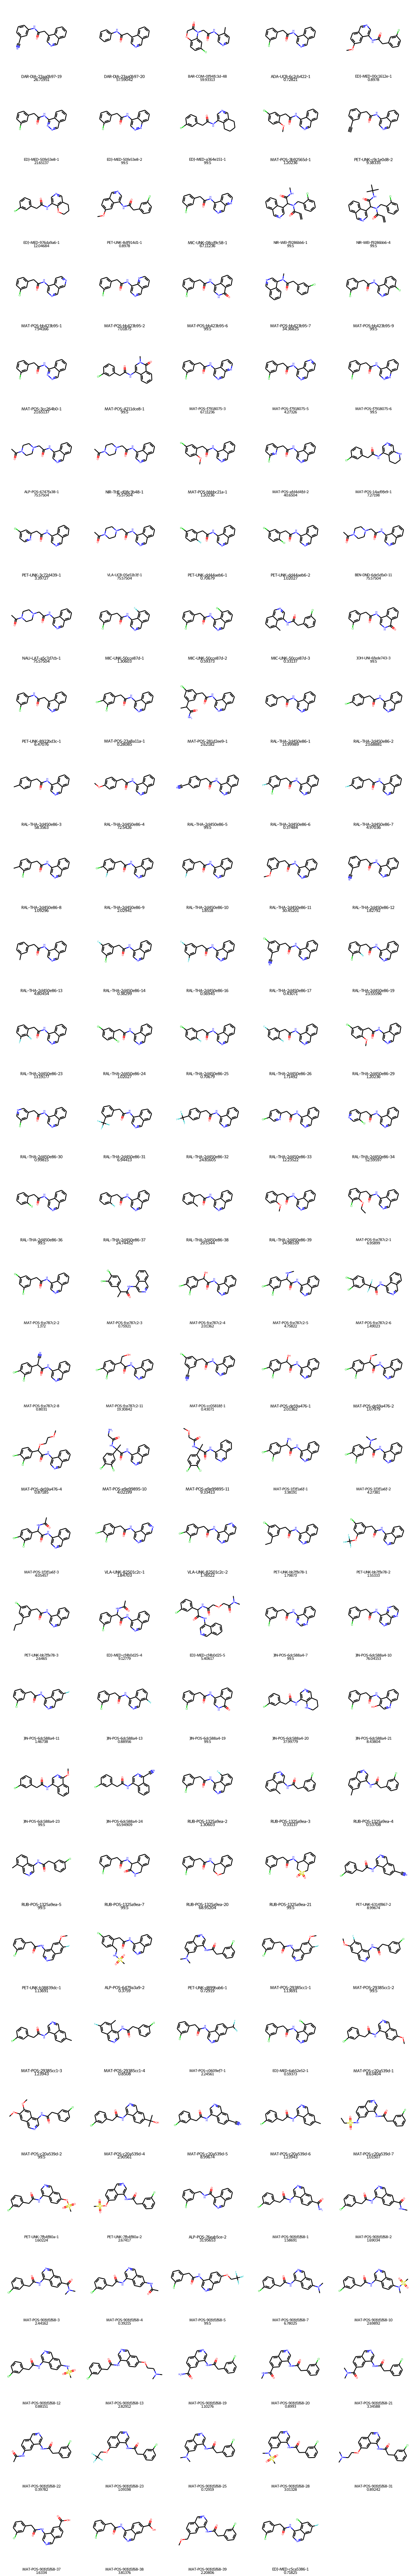

In [34]:
mols_to_show = [Chem.MolFromSmiles(x) for x in list(final_ligand_series["SMILES"])]
legends = [x+"\n"+str(round(y,5)) for x,y in zip(list(final_ligand_series["CID"]), list(final_ligand_series["f_avg_IC50"]))]
display(Draw.MolsToGridImage(mols_to_show,subImgSize=(200,200),molsPerRow=5,maxMols=170,legends=legends))

In [35]:
len(mols_to_show)

154

In [36]:
from rdkit.Chem.rdFMCS import FindMCS
from rdkit.Chem.rdFMCS import AtomCompare
from rdkit.Chem.rdFMCS import RingCompare
from rdkit.Chem.rdFMCS import BondCompare

In [37]:
c = FindMCS(mols_to_show, 
            atomCompare=AtomCompare.CompareAny,
            ringCompare=RingCompare.IgnoreRingFusion,
            bondCompare=BondCompare.CompareAny,
            #completeRingsOnly=True
            #threshold=0.8,#Much slower
           )

In [38]:
c.smartsString

'[#6,#7](-[#6,#7]-[#6,#7]1:,-[#6,#7]:,-[#7,#6,#8,#16]:,-[#6,#7,#8]:,-[#6]2:[#6]:,-1:,-[#6,#7,#8]:,-[#6,#7]:,-[#6,#7]:,-[#6,#7]:,-2)-[#7,#6]-[#6,#7]1:,-[#6]:,-[#6,#7]:,-[#6,#7]:,-[#6]:,-[#6,#7]:,-1'

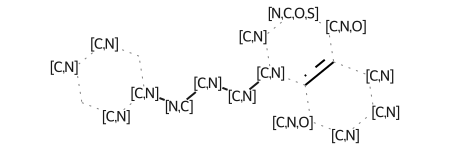

In [39]:
core = Chem.MolFromSmarts(c.smartsString)
core

In [45]:
scaffolds = list(df.loc[df["ASSAYED"]].groupby("mHashGeneric")["CID"].count().nlargest(50).index)

In [47]:
scaffold_mols = [Chem.MolFromSmiles(x) for x in scaffolds]

In [46]:
display(Draw.MolsToGridImage(scaffold_mols,subImgSize=(200,200),molsPerRow=5,maxMols=170,legends=legends))

'C1CCC2C(C1)CCCC2CCC1CCCC2CCCCC21'

In [54]:
sub_df = df.iloc[20000:]

In [62]:
sub_df.loc[sub_df["f_avg_IC50"]!="NaN"]["f_avg_IC50"]

index
20000         NaN
20001    0.468466
20002         NaN
20003         NaN
20004         NaN
           ...   
20992         NaN
20993         NaN
20994         NaN
20995         NaN
20996         NaN
Name: f_avg_IC50, Length: 997, dtype: float64